### second part

In [1]:
import os, sys, torch
import numpy as np
import matplotlib.pyplot as plt

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.model.train_and_eval import train_with_parameter
from src.visualization.plot_functions import prep_plot_input, set_plot_params_states,set_plot_params_expected_values,set_labels_and_colors_expected_values

In [2]:
params          ={"wc": 10, "wa": 10, "g": 0.1,"g1":0.1,"g2":0.1,"g3":0.1,"g4":0.1}#random.uniform(0.1, 1.0)
tfinal          = 40
n_time_steps    = 400
init_state      = "fock"
dims            = {"atom": 2, "field": 2}
picture         = "rabi" # "interaction", "atom" or "full"
epochs          = 10000
DEVICE         = "cpu"

In [3]:
# PARA APRENDER O ESTADO E O PARÂMETRO
# np.random.seed(42)
# torch.manual_seed(42)

models_dict, loss_dict = train_with_parameter(
    epochs      = epochs,
    params      = params,
    tfinal      = tfinal,
    n_time_steps= n_time_steps,
    init_state  = init_state,
    picture     = picture,
    dims        = dims,
    n_points_loss=n_time_steps,
    n_paramater = 4
)

/home/gubio/anaconda3/lib/python3.13/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
100%|██████████| 10000/10000 [03:22<00:00, 49.35it/s]


/home/gubio/anaconda3/lib/python3.13/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/tmp/ipykernel_2843296/3089887341.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax0.legend()


<Figure size 350x262.5 with 0 Axes>

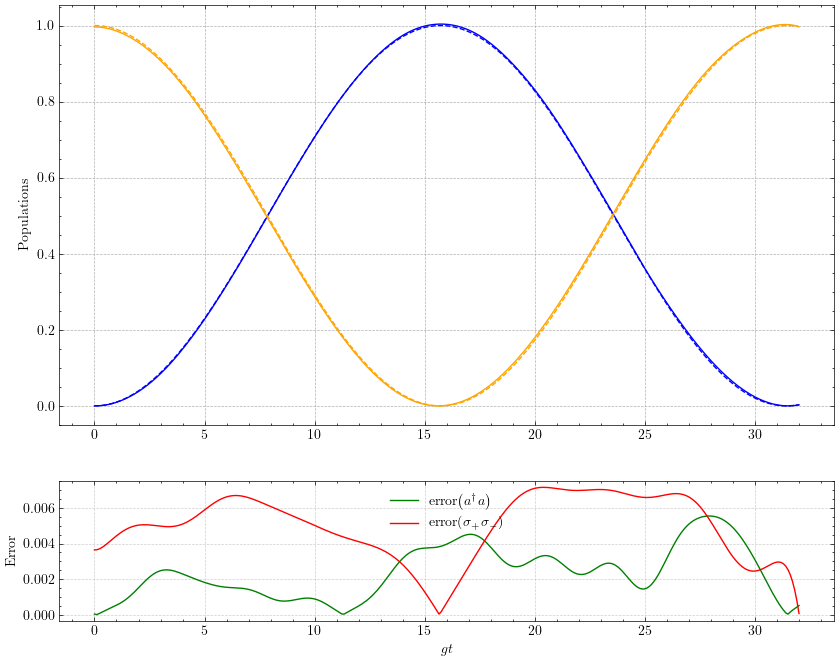

In [4]:
with plt.style.context('science'):
    plt.figure()
    (
        sim_expect_train,
        sim_expect_test,
        time_train,
        time_test,
        operators_list,
    ) = prep_plot_input(
        params, tfinal, n_time_steps, init_state, picture, dims, "expected"
    )

    ax0, ax1 = set_plot_params_expected_values()
    labels, labels_error, colors, colors_error = set_labels_and_colors_expected_values()


    for i, operator in enumerate(operators_list):
        nn_state_train = models_dict["model_real"](time_train) + 1j * models_dict[
            "model_imag"
        ](time_train)

        expected_values_train = torch.einsum(
            "ni,ij,nj->n", nn_state_train.conj(), operator, nn_state_train
        ).real

        error = abs((
            expected_values_train - sim_expect_train[:, i]
        ).detach().numpy() )

        ax0.plot(
            time_train.numpy().squeeze(),
            expected_values_train.detach().numpy(),
            #label=labels[i][0],
            color=colors[i],
        )

        ax0.plot(
            time_train.numpy().squeeze(),
            sim_expect_train[:, i].detach().numpy(),
            #label=labels[i][1],
            color=colors[i],
            linestyle="--",
        )
        ax0.legend()

        ax1.plot(
            time_train.numpy().squeeze(),
            error,
            label=labels_error[i],
            color=colors_error[i],
        )
        ax1.legend()


    plt.show()


In [5]:
loss_dict["learned_param"][-1]

[0.09958215057849884,
 0.10027509927749634,
 0.0001775076671037823,
 0.00031731330091133714]

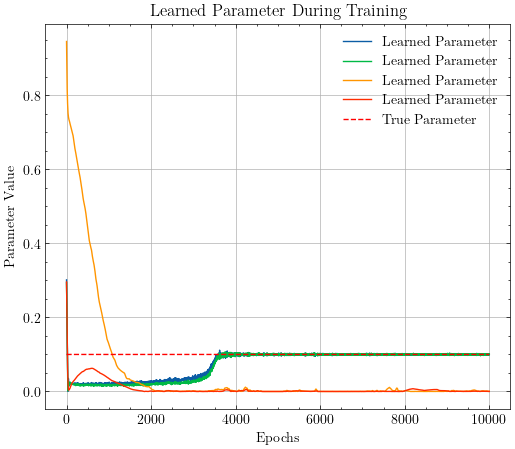

In [6]:
with plt.style.context('science'):
    plt.figure(figsize=(6, 5))
    # plt.plot(loss_dict["learned_param"])
    # plt.xlabel('Epoch')
    # # plt.ylabel('Learned g')
    # plt.title('Learned Parameter Over Epochs')
    # plt.legend(['couple g'])
    # plt.show()


    plt.plot(loss_dict["learned_param"], label="Learned Parameter")
    plt.plot([params["g"]]*len(loss_dict["learned_param"]), 'r--', label="True Parameter")
    plt.xlabel("Epochs")
    plt.ylabel("Parameter Value")
    plt.title("Learned Parameter During Training")
    plt.legend()
    plt.grid()
    #plt.yscale('log')
    plt.show()

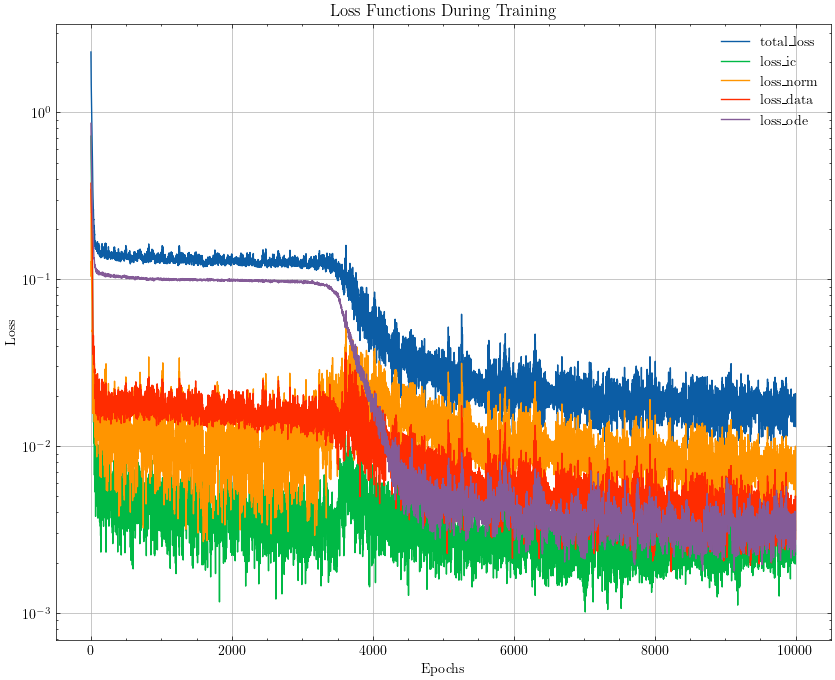

In [7]:
with plt.style.context('science'):
    plt.figure(figsize=(10, 8))
    for key, value in loss_dict.items():
        if "loss" in key:
            plt.plot(value, label=key)

    plt.yscale("log")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Functions During Training")
    plt.legend()
    plt.grid()
    #plt.yscale('log')
    plt.show()



/home/gubio/anaconda3/lib/python3.13/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


<Figure size 350x262.5 with 0 Axes>

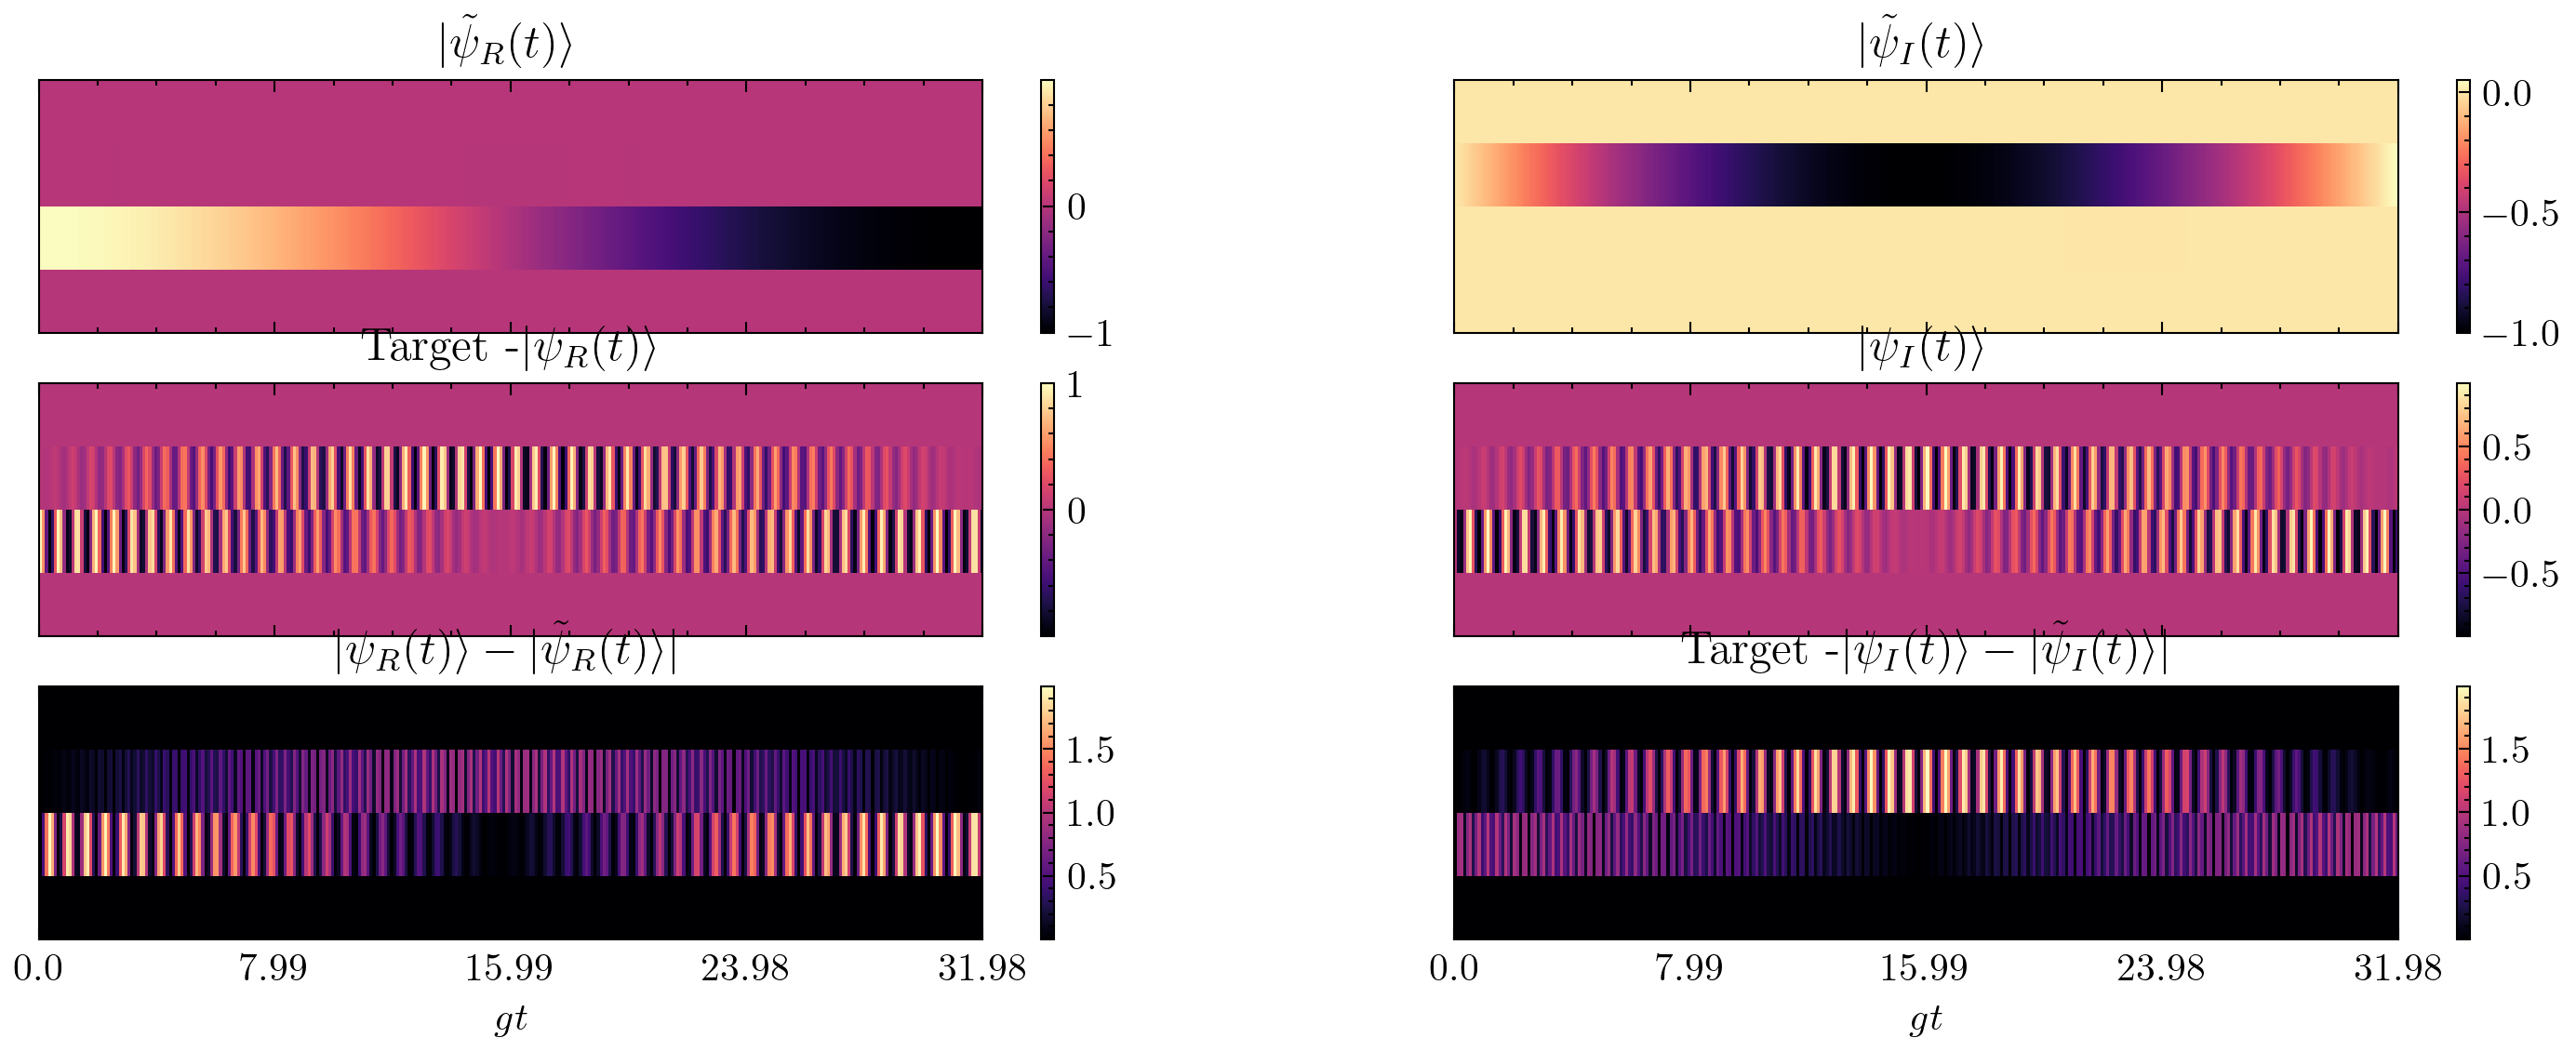

In [8]:
with plt.style.context('science'):
    plt.figure()
    sim_state_train, sim_state_test, time_train, time_test = prep_plot_input(
        params, tfinal, n_time_steps, init_state, picture, dims, "state")

    fig, axs = set_plot_params_states()
    nn_state_train_real = models_dict["model_real"](time_train)
    nn_state_train_imag = models_dict["model_imag"](time_train)

    extent = [
        time_train[0].item(),
        time_train[-1].item(),
        0,
        nn_state_train_real.shape[1],
    ]

    # REAL PART
    im = axs[0, 0].imshow(
        nn_state_train_real.detach().numpy().T,
        cmap="magma",
        extent=extent,
        aspect="auto",
    )
    fig.colorbar(im, ax=axs[0, 0], orientation="vertical")

    im = axs[1, 0].imshow(
        sim_state_train.real.T.detach().numpy(),
        cmap="magma",
        extent=extent,
        aspect="auto",
    )
    fig.colorbar(im, ax=axs[1, 0], orientation="vertical")

    im = axs[2, 0].imshow(
        abs(sim_state_train.real - nn_state_train_real).T.detach().numpy(),
        cmap="magma",
        extent=extent,
        aspect="auto",
    )
    fig.colorbar(im, ax=axs[2, 0], orientation="vertical")

    # IMAGINARY PART
    im = axs[0, 1].imshow(
        nn_state_train_imag.detach().numpy().T,
        cmap="magma",
        extent=extent,
        aspect="auto",
    )
    fig.colorbar(im, ax=axs[0, 1], orientation="vertical")

    im = axs[1, 1].imshow(
        sim_state_train.imag.T.detach().numpy(),
        cmap="magma",
        extent=extent,
        aspect="auto",
    )
    fig.colorbar(im, ax=axs[1, 1], orientation="vertical")

    im = axs[2, 1].imshow(
        abs(sim_state_train.imag - nn_state_train_imag).T.detach().numpy(),
        cmap="magma",
        extent=extent,
        aspect="auto",
    )

    fig.colorbar(im, ax=axs[2, 1], orientation="vertical")

    for ax in axs.flat:
        ax.set_xticks(
            np.linspace(time_train[0].item(), time_train[-1].item(), num=5)
        )
        ax.set_xticklabels(
            np.round(
                np.linspace(time_train[0].item(), time_train[-1].item(), num=5), 2
            )
        )
    

    plt.show()
